In [29]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"


class RBF_Add(nn.Module):
    def __init__(self, add_rbf_number, device = device):
        super(RBF_Add, self).__init__()

        self.add_rbf_number = add_rbf_number
        self.radial_layer_centers_list = []
        self.radial_sigma_list = []
        self.linear_layer_weights_list = []
        
        
        self.total_radial_layer_centers_list = []
        self.total_radial_sigma_list = []
        self.total_linear_layer_weights_list = []
        
        self.change_th = 3

    def rbf_gaussian(self, input_data):
        output = torch.exp(-1 * (torch.pow((input_data - self.radial_layer_centers), 2) / \
                                 (torch.pow(self.radial_sigma, 2))))

        return output  # size = (num_rbf, 1)

    def done_rbf_gaussian(self, input_data, number):
        output = torch.exp(-1 * (torch.pow(
            (input_data - self.done_radial_layer_centers[number - 1 - self.add_rbf_number:number - 1]), 2) / \
                                 (torch.pow(self.done_radial_sigma[number - 1 - self.add_rbf_number:number - 1], 2))))

        return output  # size = (num_rbf, 1)

    def rbf_gaussian_derivative_centers(self, input_data):
        output = (2 * (input_data - self.radial_layer_centers) / \
                  (torch.pow(self.radial_sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)
    '''
    def rbf_gaussian_derivative_centers2(self, input_data):
        output = (2 / (torch.pow(self.radial_sigma, 2))) * self.rbf_gaussian(input_data) + \
                ((-2* (input_data - self.radial_layer_centers) / torch.pow(self.radial_sigma,2)) * \
                 self.rbf_gaussian_derivative_centers(input_data))

        return output  # size = (num_radial, 1)
    '''
    def rbf_gaussian_derivative_sigma(self, input_data):
        output = (2 * torch.pow((input_data - self.radial_layer_centers), 2) / \
                  (torch.pow(self.radial_sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)
    '''
    def rbf_gaussian_derivative_sigma2(self, input_data):
        output = (4 * (input_data - self.radial_layer_centers) / (torch.pow(self.radial_sigma, 3))) * \
                    self.rbf_gaussian(input_data) + (-2*(input_data - self.radial_layer_centers) / torch.pow(self.radial_sigma, 2)) * \
                    self.rbf_gaussian_derivative_sigma(input_data)

        return output  # size = (num_radial, 1)
    '''
    def rbf_gradient(self, input_data, centers, sigmas, weights):
        rbf_output = (-2 * (input_data-centers) / torch.pow(sigmas,2)) * \
                        (torch.exp(-1 * (torch.pow((input_data - centers), 2) / (torch.pow(sigmas, 2)))))
        rbf_grad = torch.mm(weights, rbf_output)
        
        return rbf_grad
    
    def first_grad(self, input_data, target):
        space = (input_data,)
        f_grad = torch.gradient(target[0], spacing = space, edge_order  = 1)
        return f_grad[0]
    
    def target_grad(self, input_data, centers, sigmas, weights, f_grad):
        true_grad = f_grad - self.rbf_gradient(input_data, centers, sigmas, weights)
        
        return true_grad
    
    def Loss(self, pred, target, pred_grad, true_grad):
        
        return torch.mean(torch.pow(target - pred,2) + torch.pow(true_grad - pred_grad, 2))

    def forward(self, input_data):
        rbf_output = self.rbf_gaussian(input_data)
        pred = torch.mm(self.linear_layer_weights, rbf_output)

        return rbf_output, pred

    def pred(self, input_data):
        rbf_output = torch.exp(-1 * (torch.pow((input_data - self.done_radial_layer_centers), 2) / \
                                     (torch.pow(self.done_radial_sigma, 2))))
        pred = torch.mm(self.done_linear_layer_weights, rbf_output)

        return rbf_output, pred
    
    def L2_F(self, input_data):
        return -2 * (input_data - self.radial_layer_centers) / torch.pow(self.radial_sigma, 2)
    

    def first_rbf_parameter(self, input_data, target):
        
        time_interval = int((torch.max(input_data.diff(1)) / torch.min(input_data.diff(1)).item()))
        find_index_input = input_data.clone().detach()
        fine_index_target = target.clone().detach()
        find_sigma = target.clone().detach()
        
        target_std = target.std()
        
        find_weight = target.clone().detach()
        center_index_list = []

        for i in range(self.add_rbf_number):
            index_ = torch.argmax(torch.abs(fine_index_target)).cpu().detach().tolist()
            fine_index_target[index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)
        initweight = torch.index_select(find_weight, 0, center_index_list)
                            

        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        dft =  torch.abs(dft / torch.max(dft)) **-1
        for k in center_index_list:
            sigma_list.append(dft[k].reshape(1))
    
        initsigma = torch.cat(sigma_list)

        return initcenter[-self.add_rbf_number:], initweight[-self.add_rbf_number:], initsigma[-self.add_rbf_number:]

    def init_rbf_parameter(self, input_data, error):
        time_interval = int((torch.max(input_data.diff(1)) / torch.min(input_data.diff(1)).item()))
        find_index_input = input_data.clone().detach()
        find_index_error = error.clone().detach()
        
        find_weight = error.clone().detach()
        find_sigma = error.clone().detach()
        
        target_std = error.std()
        center_index_list = []

        for i in range(self.add_rbf_number * (self.change_time + 1)):
            index_ = torch.argmax(torch.abs(find_index_error)).cpu().detach().tolist()

            find_index_error[index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)
        initweight = torch.index_select(find_weight, 0, center_index_list)

        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        
        dft =  (torch.abs(dft / torch.max(dft))**-1)
        for k in center_index_list:
            sigma_list.append(dft[k].reshape(1))

        initsigma = torch.cat(sigma_list)

        return initcenter[-self.add_rbf_number:], initweight[-self.add_rbf_number:], initsigma[-self.add_rbf_number:]

    def change_init(self, na):
        if na == 1:
            loss_list = self.train_loss_list[-self.change_th:]
            if self.number > self.change_th and max(loss_list) == min(loss_list):
                self.change_time += 1
            elif self.number > self.change_th and loss_list[0] < loss_list[1] and loss_list[1] < loss_list[2]:
                self.change_time += 1
            else:
                self.change_time = 0
        else:
            self.change_time += 1

    def best_forward(self, input_data, best_center, best_sigma, best_weight):
        rbf_output = torch.exp(-1 * (torch.pow((input_data - best_center), 2) / \
                                     (torch.pow(best_sigma, 2))))
        pred = torch.mm(best_weight, rbf_output)

        return rbf_output, pred    
    
    def L2_2_derivateive_weight(self, input_data, radial_output):
        return (-2 *(input_data - self.radial_layer_centers) / torch.pow(self.radial_sigma,2)) * radial_output

    def backward_propagation(self, input_data, radial_output, pred, target, target_grad, pred_grad):
        
        L2_1_error = -2 * (target - pred)
        # print(pred)

        L2_2_error = -2 * (target_grad - pred_grad)
        len_ = len(L2_2_error)

        # sigma update
        deltaSigma1 = self.rbf_gaussian_derivative_sigma(input_data) * L2_1_error
        deltaSigma1 *= self.linear_layer_weights.reshape(self.add_rbf_number, 1)
        '''
        print('deltasigma1')
        print(torch.sum(deltaSigma1, dim=1))
        print('--------------------')
        '''
        deltaSigma2 = self.rbf_gaussian_derivative_sigma(input_data) * L2_2_error
        deltaSigma2 *= self.L2_F(input_data) * self.linear_layer_weights.reshape(self.add_rbf_number, 1)
        '''
        print('deltasigma2')
        print(torch.sum(deltaSigma2, dim=1))
        print('--------------------')
        '''
        deltaSigma =  torch.sum(deltaSigma1, dim=1) + torch.sum(deltaSigma2, dim=1)
        '''
        print('deltasigma')
        print(deltaSigma)
        print('--------------------')
        '''
        # center update
        deltaCenter1 = self.rbf_gaussian_derivative_centers(input_data) * L2_1_error
        deltaCenter1 *= self.linear_layer_weights.reshape(self.add_rbf_number, 1)
        '''
        print('deltacenter1')
        print(torch.sum(deltaCenter1, dim=1))
        print('--------------------')
        '''
        deltaCenter2 = self.rbf_gaussian_derivative_centers(input_data) * L2_2_error
        deltaCenter2 *= self.L2_F(input_data) * self.linear_layer_weights.reshape(self.add_rbf_number, 1)
        '''
        print('deltacenter2')
        print(torch.sum(deltaCenter2, dim=1))
        print('--------------------')
        '''
        deltaCenter =  torch.sum(deltaCenter1, dim=1) + torch.sum(deltaCenter2, dim=1)
        '''
        print('deltacenter')
        print(deltaCenter)
        print('--------------------')
        '''
        # weight update
        delta_weight1 = torch.sum((radial_output * L2_1_error), dim=1)
        delta_weight1 = delta_weight1.reshape(1, self.add_rbf_number)
        '''
        print('deltaweight1')
        print(delta_weight1)
        print('--------------------')
        '''
        delta_weight2 = torch.sum((self.L2_2_derivateive_weight(input_data, radial_output) * L2_2_error), dim = 1)
        delta_weight2 = delta_weight2.reshape(1, self.add_rbf_number)
        '''
        print('deltaweight2')
        print(delta_weight2)
        print('--------------------')
        '''
        delta_weight = delta_weight1 + delta_weight2
        '''
        print('deltaweight')
        print(delta_weight)
        print('--------------------')
        '''
        
        # BP update
        self.linear_layer_weights -= self.lr * delta_weight
        #self.radial_layer_centers -= self.lr * torch.sum(deltaCenter1, dim=1).reshape(self.add_rbf_number, 1)
        #self.radial_sigma -= self.lr * torch.sum(deltaSigma1, dim=1).reshape(self.add_rbf_number, 1)
        self.radial_layer_centers -= self.lr * deltaCenter.reshape(self.add_rbf_number, 1)
        self.radial_sigma -= self.lr * deltaSigma.reshape(self.add_rbf_number, 1)
        
    def train(self, input_data, target, epochs, lr, loss_th, lr_change_th):
        self.lr = lr

        self.target = target.clone().detach()
        self.number = 0
        self.train_loss_list = []
        self.loss_th = loss_th
        self.change_time = 0
        self.round_number = 5
        self.target_mape_th = torch.mean(torch.abs(target)) * 0.05
        self.lr_change_th = lr_change_th
        count_loss_chage = 0
        count_round_change = 0

        break_time = len(input_data) / self.add_rbf_number
        loss = 100000

        while self.loss_th < loss:
            print(self.number)
            # first rbf
            if self.number == 0:
                cent, weig, sig = self.first_rbf_parameter(input_data, self.target[0])
            
                self.radial_layer_centers = cent.reshape(self.add_rbf_number, 1)
                self.radial_sigma = sig.reshape(self.add_rbf_number, 1)
                self.linear_layer_weights = weig.reshape(1, self.add_rbf_number)
                first_grad = self.first_grad(input_data, target)
                for epo in range(epochs):
                    # print("epoch : {}".format(epo))
                    radial_output, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.radial_layer_centers, self.radial_sigma, self.linear_layer_weights)
                    
                    self.backward_propagation(input_data, radial_output, pred, self.target, first_grad, rbf_grad)
                    epo_loss = self.Loss(pred, self.target, rbf_grad, first_grad)
                    
                    if epo == 0:
                        print("{} epoch MSE Loss: {}".format(epo, epo_loss))
                        self.best_loss = epo_loss.clone().detach()
                        self.best_center = self.radial_layer_centers.clone().detach()
                        self.best_sigma = self.radial_sigma.clone().detach()
                        self.best_weight = self.linear_layer_weights.clone().detach()
                    else:
                        if self.best_loss > epo_loss:
                            self.best_loss = epo_loss.clone().detach()
                            self.best_center = self.radial_layer_centers.clone().detach()
                            self.best_sigma = self.radial_sigma.clone().detach()
                            self.best_weight = self.linear_layer_weights.clone().detach()
                    if (epo + 1) % 250 == 0:
                        print("{} epoch MSE Loss: {}".format(epo, epo_loss))

            # additional rbf
            else:
                # init parameter
                self.change_init(na)
                if self.change_time > break_time:
                    break
                cent, weig, sig = self.init_rbf_parameter(input_data, self.target[0])
               
                self.radial_layer_centers = cent.reshape(self.add_rbf_number, 1)
                self.radial_sigma = sig.reshape(self.add_rbf_number, 1)
                self.linear_layer_weights = weig.reshape(1, self.add_rbf_number)

                for epo in range(epochs):
                    # print("epoch : {}".format(epo))
                    radial_output, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.radial_layer_centers, self.radial_sigma, self.linear_layer_weights)
                    
                    if epo == 0:
                        print(self.Loss(pred, self.target, rbf_grad, target_grad))
                        self.best_loss = self.Loss(pred, self.target, rbf_grad, target_grad).clone().detach()
                        self.best_center = self.radial_layer_centers.clone().detach()
                        self.best_sigma = self.radial_sigma.clone().detach()
                        self.best_weight = self.linear_layer_weights.clone().detach()
                    
                    self.backward_propagation(input_data, radial_output, pred, self.target, target_grad, rbf_grad)
                    epo_loss = self.Loss(pred, self.target, rbf_grad, target_grad)

                    if (epo + 1) % 1000 == 0:
                        print("{} epoch MSE Loss: {}".format(epo, epo_loss))

                    # best parameter
                    if self.best_loss > epo_loss:
                        self.best_loss = epo_loss.clone().detach()
                        self.best_center = self.radial_layer_centers.clone().detach()
                        self.best_sigma = self.radial_sigma.clone().detach()
                        self.best_weight = self.linear_layer_weights.clone().detach()
                    
            radial_output, best_pred = self.best_forward(input_data, self.best_center, self.best_sigma,
                                                         self.best_weight)
            best_grad = self.rbf_gradient(input_data, self.best_center, self.best_sigma, self.best_weight)
            if self.number ==0:
                train_loss = self.Loss(best_pred, self.target, best_grad, first_grad)
            else:
                train_loss = self.Loss(best_pred, self.target, best_grad, target_grad)

            print('train_loss', train_loss)
            print("best loss : ", self.best_loss)

            if self.best_loss < self.lr_change_th:
                count_loss_chage += 1
                self.lr *= 10
                self.lr_change_th *= 0.03
                print("change lr ", self.lr)
                print('----------------------------------------------')

            if count_round_change == 0 and train_loss < self.target_mape_th:
                count_round_change += 1
                self.round_number += 1
                print("change round number", self.round_number)
                print('----------------------------------------------')

            self.train_loss_list.append(torch.round(train_loss * (10 ** self.round_number)) / 10 ** self.round_number)

            # additional rbf plot print
            
            plt.figure(figsize=(10, 5))
            plt.plot(input_data.cpu().detach().numpy(), self.target[0].cpu().detach().numpy())
            plt.plot(input_data.cpu().detach().numpy(), best_pred[0].cpu().detach().numpy())
            plt.show()
            
            if torch.isnan(train_loss) == False:
                na = 1
                self.target = self.target - best_pred  # target update
                loss = train_loss  # loss update
                self.number += 1  # additional rbf number update
                self.radial_layer_centers_list.append(self.best_center)
                self.radial_sigma_list.append(self.best_sigma)
                self.linear_layer_weights_list.append(self.best_weight)

                self.done_radial_layer_centers = torch.cat(self.radial_layer_centers_list, 0)
                self.done_radial_sigma = torch.cat(self.radial_sigma_list, 0)
                self.done_linear_layer_weights = torch.cat(self.linear_layer_weights_list, 1)
                target_grad = self.target_grad(input_data, self.done_radial_layer_centers, self.done_radial_sigma, self.done_linear_layer_weights, first_grad)
            else:
                na = 0

In [30]:
import numpy as np
a = np.arange(0,10,0.05)
    
y = 2*a**3 - 16*a**2 + 2*a -10
y2 = 3*a**2 -16*a - 30
y3 = 5*a**2 +25*a - a**3

target = np.array((y,y2,y3))
target = torch.tensor(target, device = device).reshape((3,200))
input_ = torch.tensor(a, device = device)
single_target = torch.tensor(np.array(y), device = device, dtype=float).reshape(1,200)

In [31]:
def plot_train(input_data, in_feature, target): #done
    if in_feature != 1:
        fig, ax = plt.subplots(1, in_feature, figsize = (30, 5))
        for i in range(in_feature):
            ax[i].plot(input_data.cpu().detach().numpy(), target[i].cpu().detach().numpy())
            #ax[i].plot(input_data.cpu().detach().numpy(), best_pred[i].cpu().detach().numpy())
        plt.show()
    
    else:
        plt.plot(input_data.cpu().detach().numpy(), target[0].cpu().detach().numpy())
        #plt.plot(input_data.cpu().detach().numpy(), best_pred[0].cpu().detach().numpy())
        plt.show()

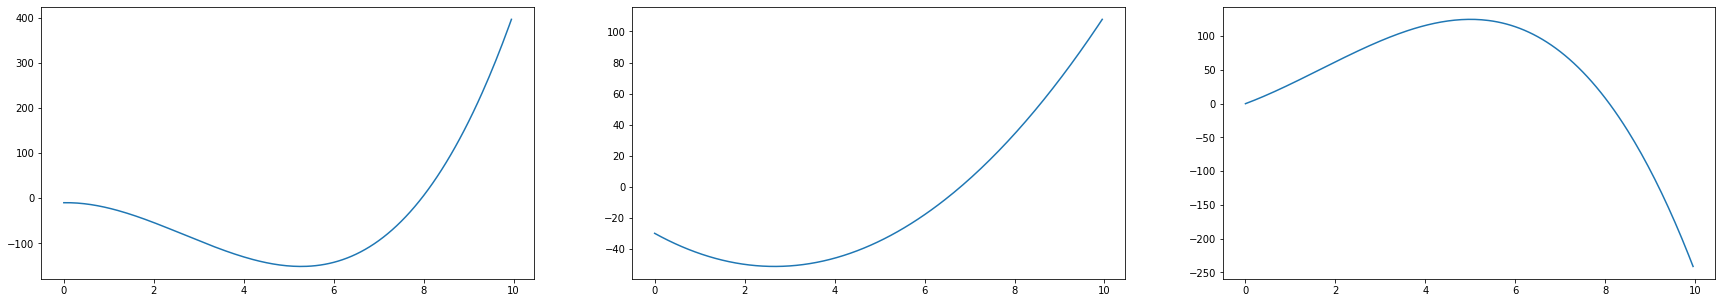

In [32]:
plot_train(input_, 3, target)

0
0 epoch MSE Loss: 4873840.603454525
249 epoch MSE Loss: 28047.450761267362
499 epoch MSE Loss: 23986.378730862634
749 epoch MSE Loss: 24122.76831634815
999 epoch MSE Loss: 15211.334016405986
1249 epoch MSE Loss: 14805.147726944724
1499 epoch MSE Loss: 12623.491860178146
1749 epoch MSE Loss: 13560.555914777231
1999 epoch MSE Loss: 13503.607433483894
2249 epoch MSE Loss: 13457.406593046406
2499 epoch MSE Loss: 13418.42117172433
2749 epoch MSE Loss: 13383.955219190593
2999 epoch MSE Loss: 13352.261315981625
train_loss tensor(29537.3349, device='cuda:0', dtype=torch.float64)
best loss :  tensor(11814.8478, device='cuda:0', dtype=torch.float64)


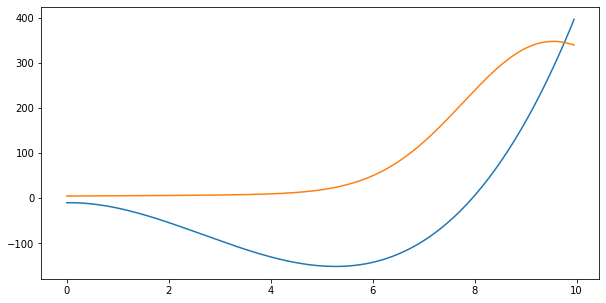

1
tensor(7034120.9857, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 10719.427301573724
1999 epoch MSE Loss: 10189.667531051604
2999 epoch MSE Loss: 5265.448052156202
train_loss tensor(5265.4477, device='cuda:0', dtype=torch.float64)
best loss :  tensor(5265.4481, device='cuda:0', dtype=torch.float64)


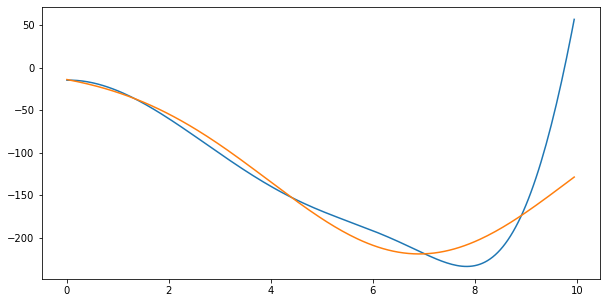

2
tensor(310135.4014, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 63.327518883279595
1999 epoch MSE Loss: 58.30576182168969
2999 epoch MSE Loss: 54.53852277258939
train_loss tensor(54.5349, device='cuda:0', dtype=torch.float64)
best loss :  tensor(54.5385, device='cuda:0', dtype=torch.float64)
change lr  9.999999999999999e-06
----------------------------------------------


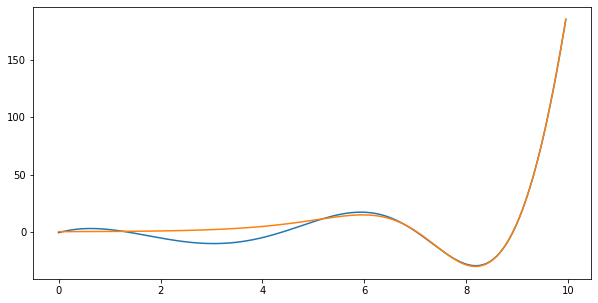

3
tensor(53219.4394, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 47.74491459818842
1999 epoch MSE Loss: 47.71652814041735
2999 epoch MSE Loss: 47.68358800293088
train_loss tensor(47.6836, device='cuda:0', dtype=torch.float64)
best loss :  tensor(47.6836, device='cuda:0', dtype=torch.float64)


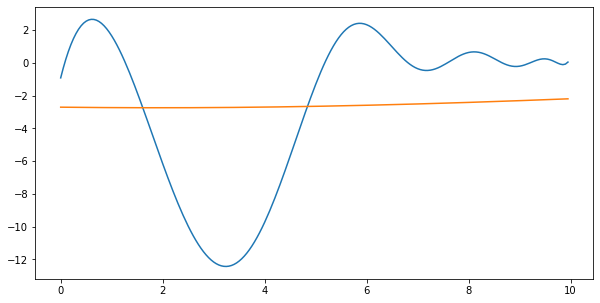

4
tensor(24500.0752, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 41.29228192864382
1999 epoch MSE Loss: 21.05284805618152
2999 epoch MSE Loss: 9.61926914388118
train_loss tensor(9.6141, device='cuda:0', dtype=torch.float64)
best loss :  tensor(9.6193, device='cuda:0', dtype=torch.float64)


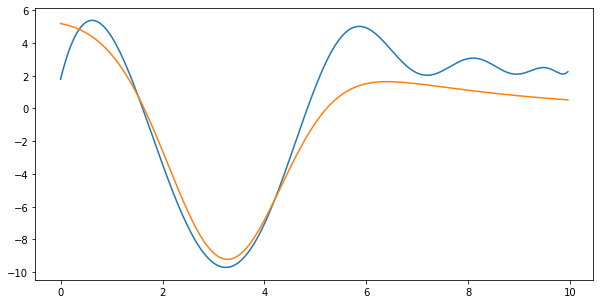

5
tensor(2514.4675, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 4.576861414042029
1999 epoch MSE Loss: 4.245727999811214
2999 epoch MSE Loss: 4.063366761085986
train_loss tensor(4.0632, device='cuda:0', dtype=torch.float64)
best loss :  tensor(4.0634, device='cuda:0', dtype=torch.float64)
change round number 6
----------------------------------------------


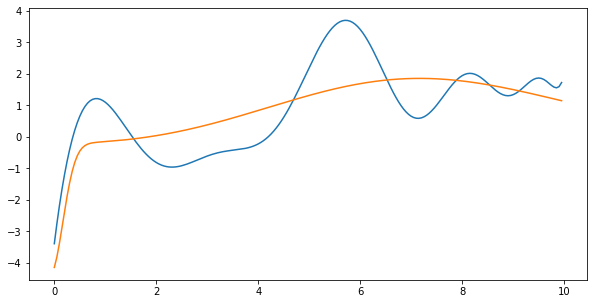

In [33]:
model = RBF_Add(20, device)
model.train(input_,single_target, 3000, 0.000001, 5, 100)

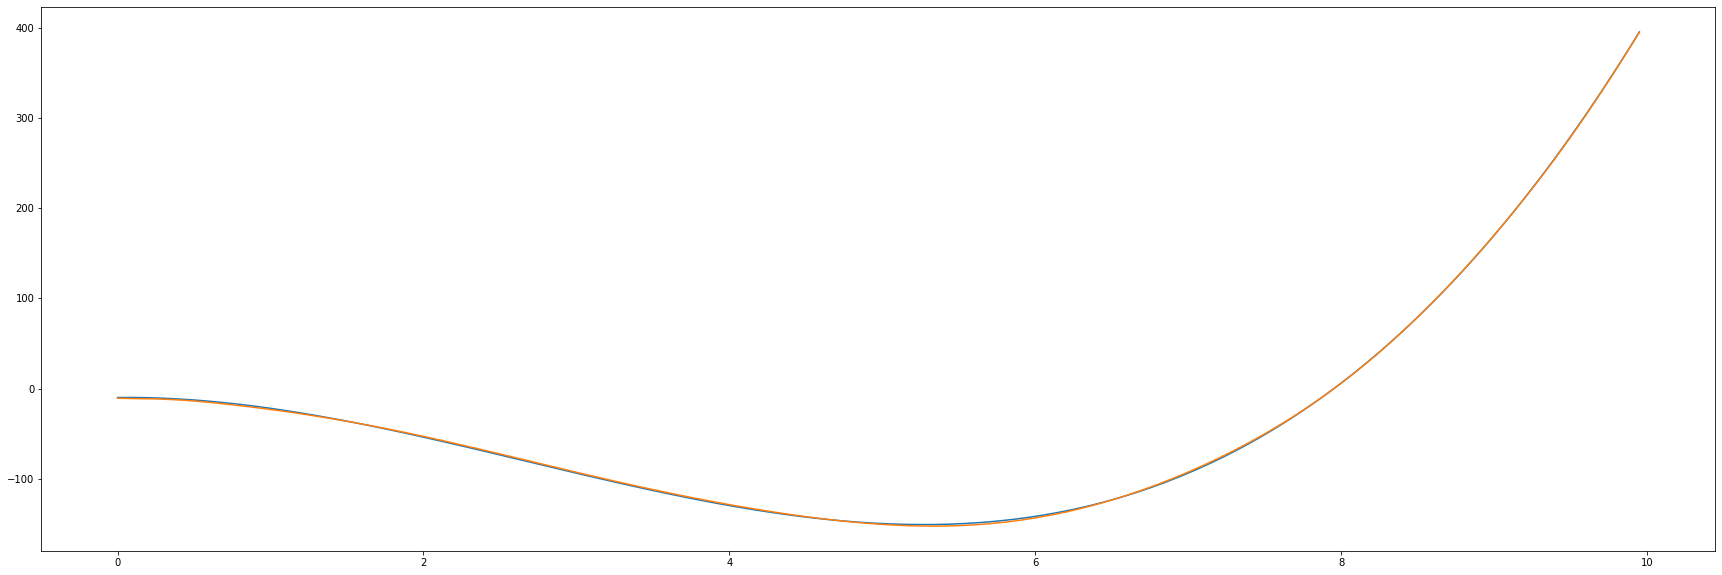

In [ ]:
plt.figure(figsize=(30, 10))
plt.plot(input_.cpu().detach().numpy(), target[0].cpu().detach().numpy())
plt.plot(input_.cpu().detach().numpy(), model.pred(input_)[1][0].cpu().detach().numpy())
plt.show()

In [34]:
single_target2 = torch.tensor(np.array(y2), device = device, dtype=float).reshape(1,200)

0
0 epoch MSE Loss: 521404.15086368594
249 epoch MSE Loss: 1252.2393930861604
499 epoch MSE Loss: 1238.3266706916215
749 epoch MSE Loss: 1233.1649879217882
999 epoch MSE Loss: 1230.8176766593906
1249 epoch MSE Loss: 1229.6397364571937
1499 epoch MSE Loss: 1228.926476243201
1749 epoch MSE Loss: 1228.4505778929074
1999 epoch MSE Loss: 1228.0419897426434
2249 epoch MSE Loss: 1227.7998733005034
2499 epoch MSE Loss: 1227.5980850981334
2749 epoch MSE Loss: 1227.3689613794347
2999 epoch MSE Loss: 1227.1543482203776
train_loss tensor(1227.1536, device='cuda:0', dtype=torch.float64)
best loss :  tensor(1227.1543, device='cuda:0', dtype=torch.float64)


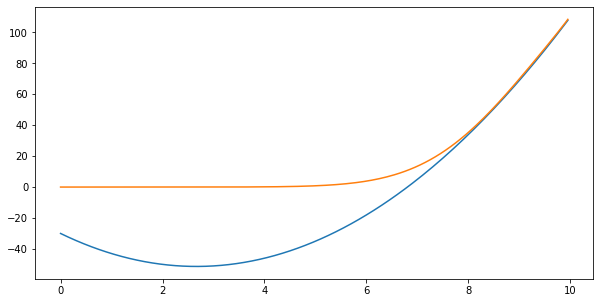

1
tensor(386149.3198, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 1387.3506012034666
1999 epoch MSE Loss: 592.1042680700284
2999 epoch MSE Loss: 475.2452339791935
train_loss tensor(475.1977, device='cuda:0', dtype=torch.float64)
best loss :  tensor(475.2452, device='cuda:0', dtype=torch.float64)


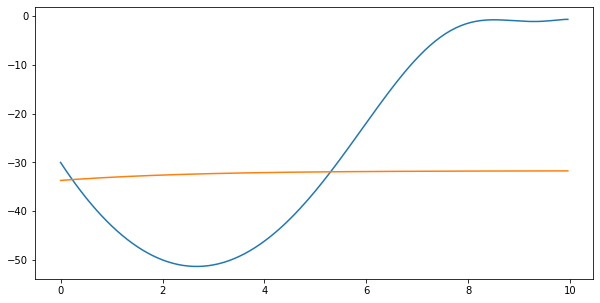

2
tensor(79500.3464, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 156.0105367710894
1999 epoch MSE Loss: 145.79131905012946
2999 epoch MSE Loss: 143.41990245545227
train_loss tensor(143.4181, device='cuda:0', dtype=torch.float64)
best loss :  tensor(143.4199, device='cuda:0', dtype=torch.float64)


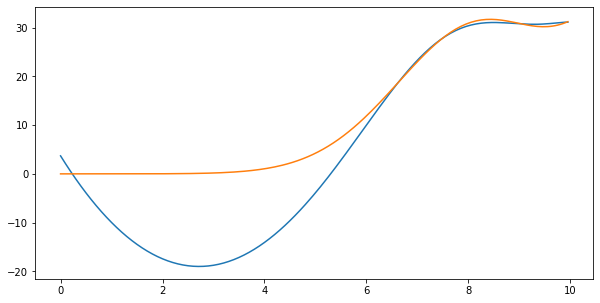

3
tensor(103156.6479, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 99.85904184472726
1999 epoch MSE Loss: 81.47890462649731
2999 epoch MSE Loss: 69.38893715725283
train_loss tensor(69.3845, device='cuda:0', dtype=torch.float64)
best loss :  tensor(69.3889, device='cuda:0', dtype=torch.float64)
change lr  9.999999999999999e-06
----------------------------------------------


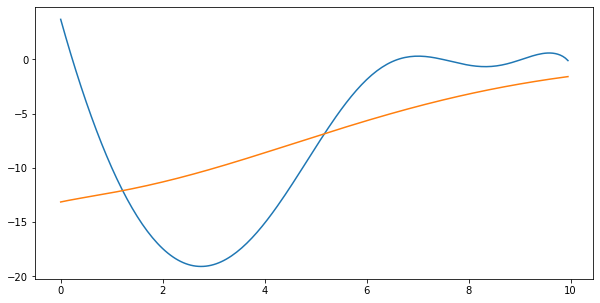

4
tensor(3000.4917, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 0.7921140625654775
1999 epoch MSE Loss: 0.7781627948164298
2999 epoch MSE Loss: 0.7692202873859371
train_loss tensor(0.7692, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.7692, device='cuda:0', dtype=torch.float64)
change lr  9.999999999999999e-05
----------------------------------------------
change round number 6
----------------------------------------------


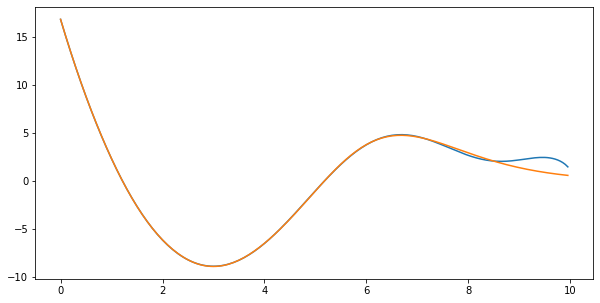

In [36]:
model2 = RBF_Add(20, device)
model2.train(input_,single_target2, 3000, 0.000001, 5, 100)

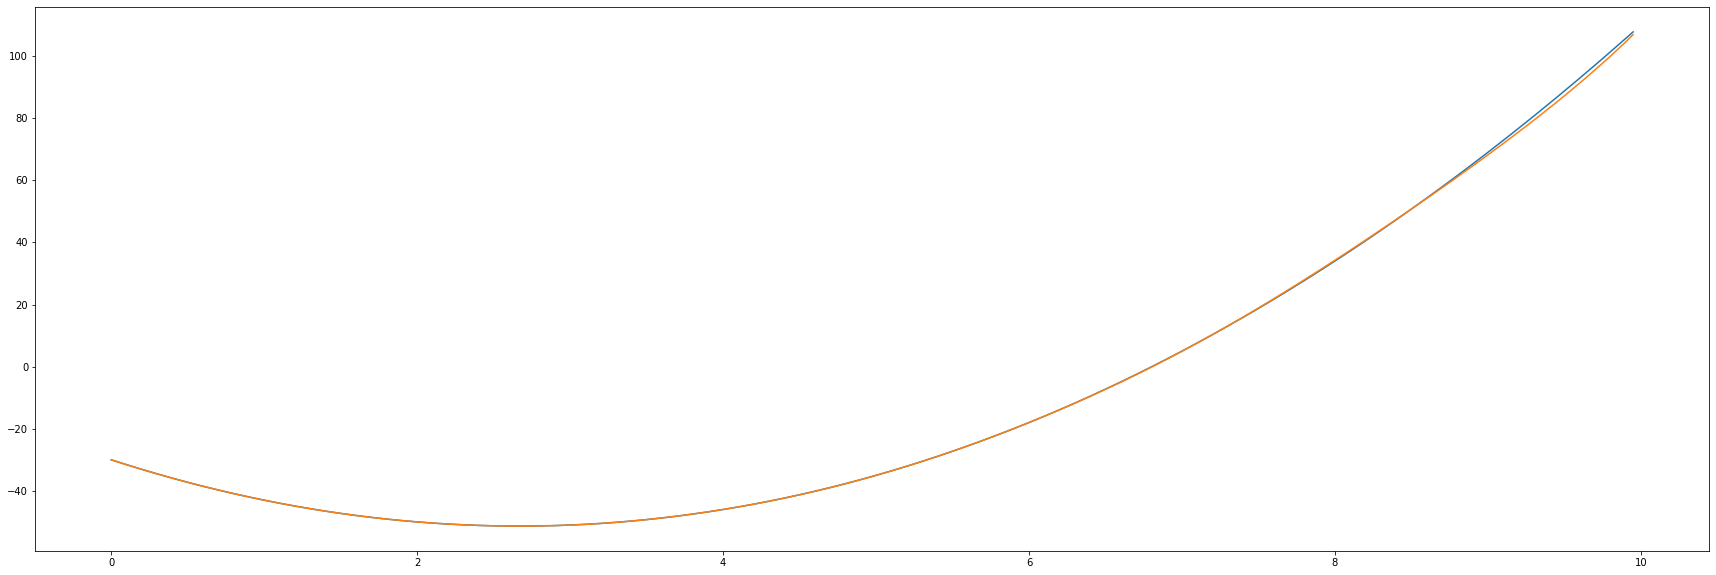

In [37]:
plt.figure(figsize=(30, 10))
plt.plot(input_.cpu().detach().numpy(), single_target2[0].cpu().detach().numpy())
plt.plot(input_.cpu().detach().numpy(), model2.pred(input_)[1][0].cpu().detach().numpy())
plt.show()

0
0 epoch MSE Loss: 1314077.0358547347
249 epoch MSE Loss: 9.404171059971535
499 epoch MSE Loss: 7.979574122045068
749 epoch MSE Loss: 7.412786510393508
999 epoch MSE Loss: 6.933256022447417
1249 epoch MSE Loss: 6.506781814271008
1499 epoch MSE Loss: 6.124797355032994
1749 epoch MSE Loss: 5.784376021595708
1999 epoch MSE Loss: 5.484009590600144
2249 epoch MSE Loss: 5.221941799228812
2499 epoch MSE Loss: 4.995555975783443
2749 epoch MSE Loss: 4.801327183041083
2999 epoch MSE Loss: 4.635080126658671
train_loss tensor(4.6345, device='cuda:0', dtype=torch.float64)
best loss :  tensor(4.6351, device='cuda:0', dtype=torch.float64)
change lr  9.999999999999999e-06
----------------------------------------------


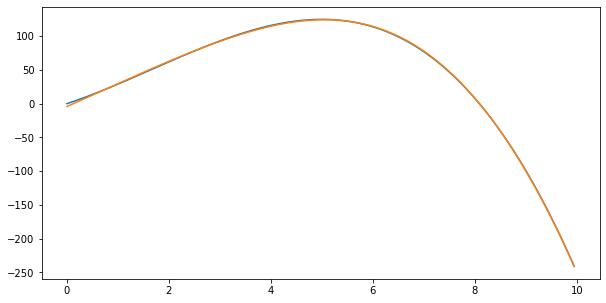

In [38]:
single_target3 = torch.tensor(np.array(y3), device = device, dtype=float).reshape(1,200)
model3 = RBF_Add(20, device)
model3.train(input_,single_target3, 3000, 0.000001, 5, 100)

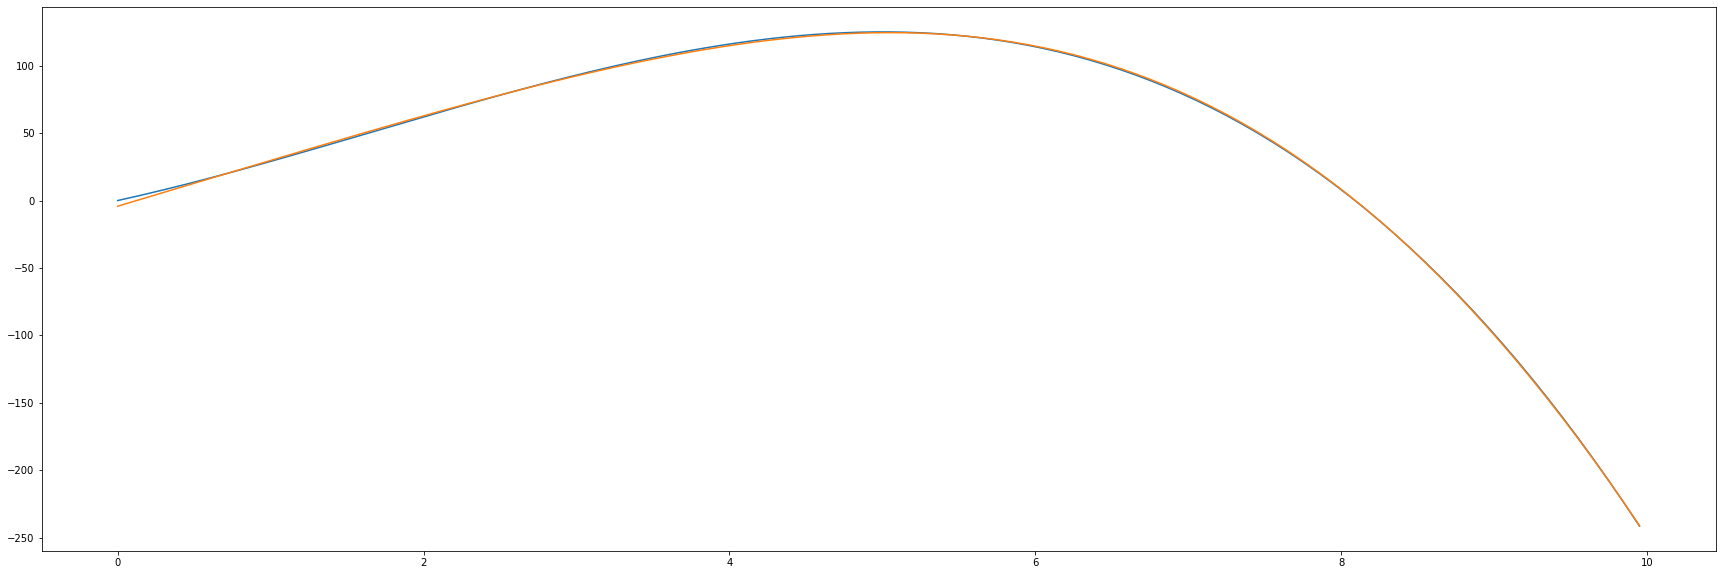

In [39]:
plt.figure(figsize=(30, 10))
plt.plot(input_.cpu().detach().numpy(), single_target3[0].cpu().detach().numpy())
plt.plot(input_.cpu().detach().numpy(), model3.pred(input_)[1][0].cpu().detach().numpy())
plt.show()